In [1]:
import deepchem as dc
from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
from openpom.utils.data_utils import get_class_imbalance_ratio, IterativeStratifiedSplitter
from openpom.models.mpnn_pom import MPNNPOMModel
from datetime import datetime
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import pubchempy as pcp
import matplotlib.pyplot as plt

2025-02-22 19:07:01.277498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-22 19:07:01.462004: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-22 19:07:01.623014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740247621.775510  671988 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740247621.815032  671988 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regist

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


/home/colin/anaconda3/envs/open_test/lib/python3.9/site-packages/torchvision-0.15.2-py3.9-linux-x86_64.egg/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/colin/anaconda3/envs/open_test/lib/python3.9/site-packages/torchvision-0.15.2-py3.9-linux-x86_64.egg/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major b

save train and test splits

load splits

set parameters

In [15]:
from deepchem.metrics import Metric
from deepchem import metrics

# learning_rate = 0.001
learning_rate = dc.models.optimizers.ExponentialDecay(initial_rate=0.001, decay_rate=0.5, decay_steps=32*20, staircase=True)

metric = Metric(metrics.roc_auc_score)

metrics_plu = [Metric(dc.metrics.accuracy_score), Metric(metrics.roc_auc_score), Metric(metrics.jaccard_score), Metric(metrics.f1_score)]

# run this cell if detailed log is needed

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [ ]:
# no of models in the ensemble
n_layer = 5
n_models = 1

# no of epochs each model is trained for
nb_epoch = 30

Get test score from the ensemble

In [1]:
for metr in ['accuracy_score','roc_auc_score', 'jaccard_score']:
    for (dim,scores) in models_dict.items():
        plt.boxplot([score[metr] for score in scores], positions=[dim], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in models_dict.keys()])
    plt.axis([0,6,0,1])
    plt.title(metr)
    plt.show()

ZeroDivisionError: division by zero

In [2]:
x = [dim for _ in scores for (dim,scores) in models_dict.items()]
y = [sc for sc in scores for (_,scores) in models_dict.items()]
plt.scatter(x,y)
plt.axis([0,6,0.85,0.95])
plt.show()

NameError: name 'scores' is not defined

In [24]:
roc_auc_score(test_dataset.y, ensemble_preds, average="macro")

0.914704818729364

## Incorporation de la structure hiérarchique des odeurs
on utilise la bibliothéque rdflib pour les odeurs.

On transforme les CAS en smiles

In [7]:
df_od = pd.read_csv('Mol_odeur.csv')
TASKS = list(df_od.columns)
TASKS.remove("Smiles")
TASKS.remove("CAS")
n_tasks = len(TASKS)

dans les labels il n'y a pas que des odeurs mais aussi d'autres éléments qui possède des odeurs

Avant de travailler sur la Strucure hiérachique on tout d'abord donné l'ensemble des donné pour avoir un point de comparaison

de façon harbitraire on va définir le nombre de couche à 3

In [12]:
n_models=5
learning_rate = 0.001
nb_epoch=30
Models=[]

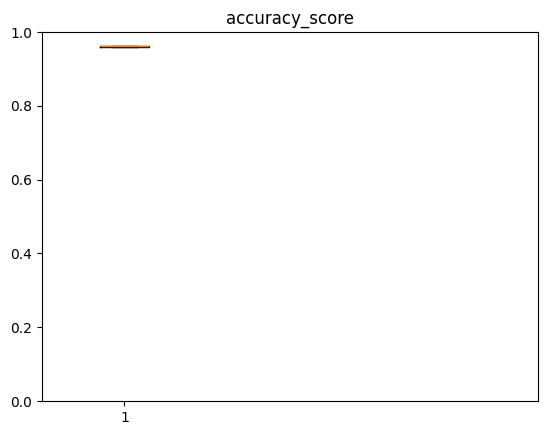

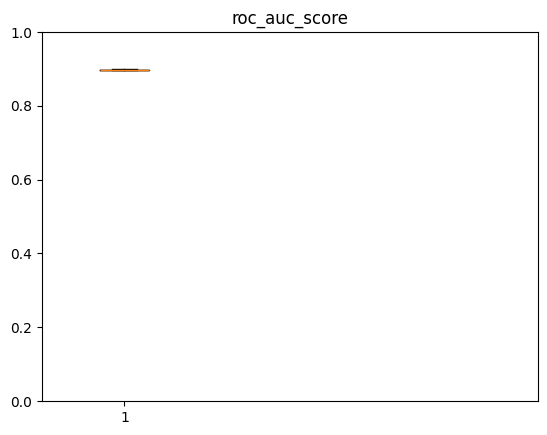

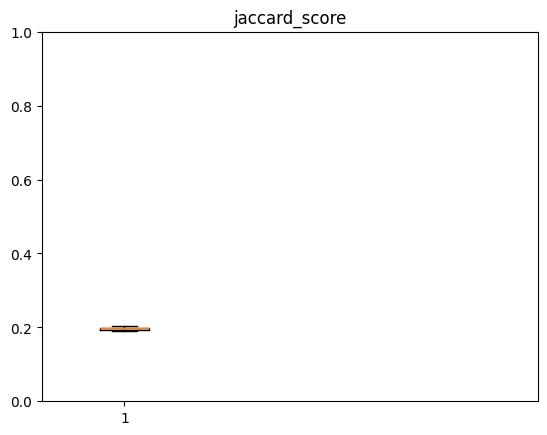

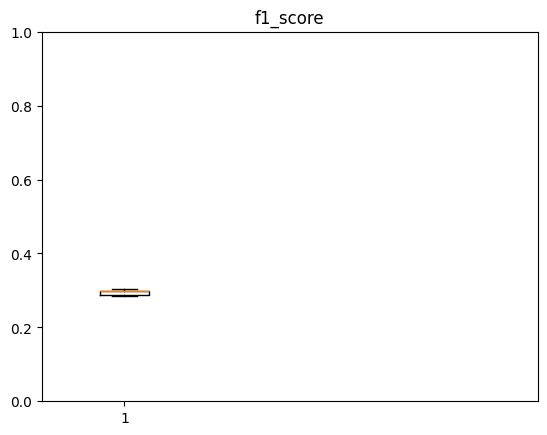

In [21]:
scores = [model.evaluate(test_dataset, metrics_plu) for model in Models]
for metr in test_scores.keys():
    plt.boxplot([score[metr] for score in scores], widths=0.6)
    #plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in models_dict.keys()])
    plt.axis([0,6,0,1])
    plt.title(metr)
    plt.show()

In [19]:
def split_train_test(input_file, TASKS):
    featurizer = GraphFeaturizer()
    smiles_field = 'Smiles'
    loader = dc.data.CSVLoader(tasks=TASKS,
                    feature_field=smiles_field,
                    featurizer=featurizer)
    
    dataset = loader.create_dataset(inputs=[input_file])
    n_tasks = len(dataset.tasks)
    
    # # get train valid test splits
    splitter = IterativeStratifiedSplitter(order=2)
    train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train=0.8)
    
    train_ratios = get_class_imbalance_ratio(train_dataset)
    assert len(train_ratios) == n_tasks
    return train_dataset, test_dataset, n_tasks, train_ratios

def train_mod(train_dataset, n_models, TASKS, n_tasks, train_ratios, nb_couches, directory):
    Models_dict = []
    for i in range(n_models):
        model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                                batch_size=128,
                                learning_rate=learning_rate,
                                class_imbalance_ratio = train_ratios,
                                loss_aggr_type = 'sum',
                                node_out_feats = 100,
                                edge_hidden_feats = 75,
                                edge_out_feats = 100,
                                num_step_message_passing = nb_couches,
                                mpnn_residual = True,
                                message_aggregator_type = 'sum',
                                mode = 'classification',
                                number_atom_features = GraphConvConstants.ATOM_FDIM,
                                number_bond_features = GraphConvConstants.BOND_FDIM,
                                n_classes = 1,
                                readout_type = 'set2set',
                                num_step_set2set = 3,
                                num_layer_set2set = 2,
                                ffn_hidden_list= [392, 392],
                                ffn_embeddings = 256,
                                ffn_activation = 'relu',
                                ffn_dropout_p = 0.12,
                                ffn_dropout_at_input_no_act = False,
                                weight_decay = 1e-5,
                                self_loop = False,
                                optimizer_name = 'adam',
                                log_frequency = 32,
                                model_dir = f'{directory}/model_{i}',
                                device_name='cpu')
    
        start_time = datetime.now()
        print("time start")
        
        # fit model
        loss = model_sketch.fit(
              train_dataset,
              nb_epoch=nb_epoch,
              max_checkpoints_to_keep=1,
              deterministic=False,
              restore=False)
        print("time end")
        end_time = datetime.now()
        
        train_scores = model_sketch.evaluate(train_dataset, metrics_plu)
        print(f"loss = {loss}; train_scores = {train_scores}; time_taken = {str(end_time-start_time)}")
        model_sketch.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
        Models_dict.append(model_sketch)
        del model_sketch
        torch.cuda.empty_cache()
    return Models_dict

In [20]:
n_step=5
Models_accross_dim = {i:[] for i in range(n_step)}
df = pd.read_csv("Mol_odeur_sans_doublons.csv")
TASKS = list(df.columns)
TASKS.remove("Smiles")
TASKS.remove("CAS")
train_wth_dupl, test_wth_dupl, n_tasks, train_wth_dupl_ratios = split_train_test("Mol_odeur_sans_doublons.csv")
for layer_n in tqdm(range(1,n_step+1)):
    
    Models_wth_dupl = train_mod(train_wth_dupl,n_models=5, TASKS=TASKS ,n_tasks=n_tasks, train_ratios=train_wth_dupl_ratios, nb_couches=layer_n, directory= "./models_wth_layer/layer_"+str(layer_n))
    Models_accross_dim[layer_n] = Models_wth_dupl[:]

  0%|                                                     | 0/5 [00:00<?, ?it/s]

time start
time end
loss = 2.4172935485839844; train_scores = {'accuracy_score': 0.9658460603297623, 'roc_auc_score': 0.9270201897879041, 'jaccard_score': 0.22184377518711096, 'f1_score': 0.33823502254064897}; time_taken = 0:26:54.167278
time start
time end
loss = 2.403072547912598; train_scores = {'accuracy_score': 0.9668338272167768, 'roc_auc_score': 0.9285786579314429, 'jaccard_score': 0.21071595037300436, 'f1_score': 0.3212569487196876}; time_taken = 0:23:33.060120
time start
time end
loss = 2.3693359375; train_scores = {'accuracy_score': 0.9647852337617553, 'roc_auc_score': 0.925788075151313, 'jaccard_score': 0.21144203901174619, 'f1_score': 0.3236921994585492}; time_taken = 0:16:20.954950
time start
time end
loss = 2.383829116821289; train_scores = {'accuracy_score': 0.9670500838725138, 'roc_auc_score': 0.927334674268829, 'jaccard_score': 0.20867493159383466, 'f1_score': 0.3165629068037041}; time_taken = 0:16:45.907687
time start
time end


 20%|███████▊                               | 1/5 [1:42:12<6:48:48, 6132.13s/it]

loss = 2.438678741455078; train_scores = {'accuracy_score': 0.9660243259513832, 'roc_auc_score': 0.920582051441545, 'jaccard_score': 0.1877984645478381, 'f1_score': 0.2883341533610118}; time_taken = 0:17:02.061089
time start
time end
loss = 2.412108039855957; train_scores = {'accuracy_score': 0.9668309048295373, 'roc_auc_score': 0.9303592392378699, 'jaccard_score': 0.221002873684331, 'f1_score': 0.33389809733641973}; time_taken = 0:27:30.289760
time start
time end
loss = 2.407115173339844; train_scores = {'accuracy_score': 0.9678508179761885, 'roc_auc_score': 0.9289899010441426, 'jaccard_score': 0.21603395610334153, 'f1_score': 0.3255555909327325}; time_taken = 0:31:19.328717
time start
time end
loss = 2.4939252853393556; train_scores = {'accuracy_score': 0.9665708123652049, 'roc_auc_score': 0.9218164990408455, 'jaccard_score': 0.19800312632038317, 'f1_score': 0.3031441720686931}; time_taken = 0:17:43.710831
time start
time end
loss = 2.471513557434082; train_scores = {'accuracy_score'

 40%|███████████████▌                       | 2/5 [3:28:54<5:14:33, 6291.12s/it]

loss = 2.3827129364013673; train_scores = {'accuracy_score': 0.9673277106602841, 'roc_auc_score': 0.9264564239104118, 'jaccard_score': 0.21411187825292297, 'f1_score': 0.3244418977306235}; time_taken = 0:14:10.973753
time start
time end
loss = 2.474436378479004; train_scores = {'accuracy_score': 0.9665678899779654, 'roc_auc_score': 0.9255145925573595, 'jaccard_score': 0.20775631707969774, 'f1_score': 0.3162723901588194}; time_taken = 0:20:14.808002
time start
time end
loss = 2.5325355529785156; train_scores = {'accuracy_score': 0.9647472427276393, 'roc_auc_score': 0.9194219728276709, 'jaccard_score': 0.18699389421991183, 'f1_score': 0.288253747514319}; time_taken = 0:20:14.159460
time start
time end
loss = 2.435991096496582; train_scores = {'accuracy_score': 0.9653814007586516, 'roc_auc_score': 0.9237515730022533, 'jaccard_score': 0.20757131577646473, 'f1_score': 0.31698383777106043}; time_taken = 0:20:22.019873
time start
time end
loss = 2.483538818359375; train_scores = {'accuracy_sc

 60%|███████████████████████▍               | 3/5 [5:11:24<3:27:33, 6226.82s/it]

loss = 2.434073638916016; train_scores = {'accuracy_score': 0.967330633047524, 'roc_auc_score': 0.9267510990848377, 'jaccard_score': 0.20417198848059717, 'f1_score': 0.30918453456908235}; time_taken = 0:20:17.624393
time start
time end
loss = 2.5217247009277344; train_scores = {'accuracy_score': 0.9659629558193499, 'roc_auc_score': 0.9206642219190163, 'jaccard_score': 0.19584759688424008, 'f1_score': 0.29796843990325217}; time_taken = 0:27:51.721019
time start
time end
loss = 2.5460710525512695; train_scores = {'accuracy_score': 0.9646654158849282, 'roc_auc_score': 0.9151529847761574, 'jaccard_score': 0.18805487311826646, 'f1_score': 0.2884716851494722}; time_taken = 0:27:52.820108
time start
time end
loss = 2.5534740447998048; train_scores = {'accuracy_score': 0.965463227601363, 'roc_auc_score': 0.9135124296149032, 'jaccard_score': 0.1771181854086127, 'f1_score': 0.2729731840249861}; time_taken = 0:26:18.124425
time start
time end
loss = 2.571853256225586; train_scores = {'accuracy_sc

 80%|███████████████████████████████▏       | 4/5 [7:44:43<2:03:20, 7400.11s/it]

loss = 2.617999267578125; train_scores = {'accuracy_score': 0.9639757324963617, 'roc_auc_score': 0.913459655290549, 'jaccard_score': 0.18522975392594596, 'f1_score': 0.2857210861720557}; time_taken = 0:35:04.828877
time start
time end
loss = 2.5962779998779295; train_scores = {'accuracy_score': 0.9639202071388074, 'roc_auc_score': 0.910252416162099, 'jaccard_score': 0.16566547665510095, 'f1_score': 0.25760123806460905}; time_taken = 0:31:45.669746
time start
time end
loss = 2.6294672012329103; train_scores = {'accuracy_score': 0.9640283354666761, 'roc_auc_score': 0.9113844272638827, 'jaccard_score': 0.1703054673295173, 'f1_score': 0.263826251134601}; time_taken = 0:31:47.662767
time start
time end
loss = 2.58948974609375; train_scores = {'accuracy_score': 0.9631340849713315, 'roc_auc_score': 0.90821246846663, 'jaccard_score': 0.16409631456565635, 'f1_score': 0.25642196403305834}; time_taken = 0:32:01.511145
time start
time end
loss = 2.641067314147949; train_scores = {'accuracy_score':

100%|████████████████████████████████████████| 5/5 [10:33:48<00:00, 7605.64s/it]

loss = 2.6036611557006837; train_scores = {'accuracy_score': 0.9645689771060184, 'roc_auc_score': 0.9098351561108218, 'jaccard_score': 0.1693973550643072, 'f1_score': 0.25992732206501273}; time_taken = 0:38:38.639878


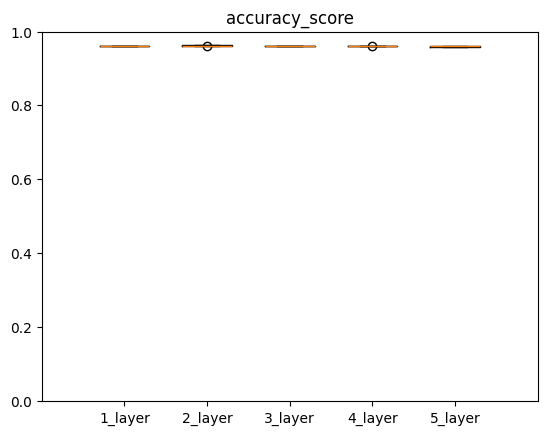

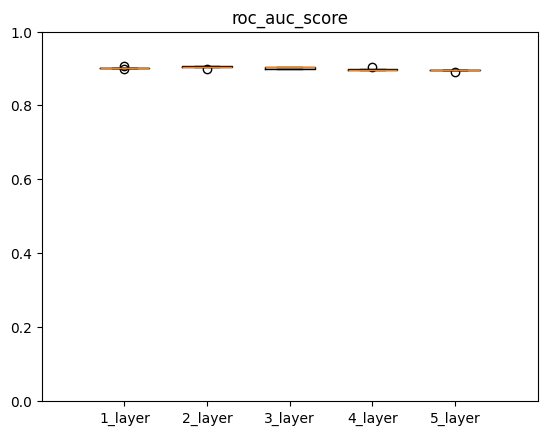

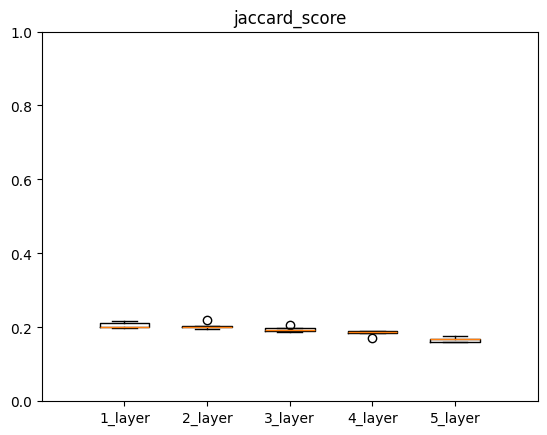

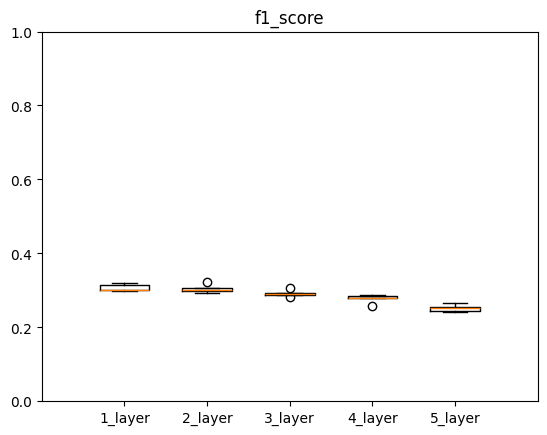

In [29]:
import matplotlib.pyplot as plt
Predictions_dictionnaire = {dim : [model.evaluate(test_wth_dupl,metrics_plu) for model in models] for (dim,models) in Models_accross_dim.items()}
indice = Predictions_dictionnaire[1][0].keys()
for metr in indice:
    for (dim,scores) in Predictions_dictionnaire.items():
        plt.boxplot([score[metr] for score in scores], positions=[dim], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in Predictions_dictionnaire.keys()])
    plt.axis([0,6,0,1])
    plt.title(metr)
    plt.show()

In [38]:
for metr in indice:
    for (dim,scores) in Predictions_dictionnaire.items():
        plt.boxplot([score[metr] for score in scores], positions=[dim], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}_layer" for dim in Predictions_dictionnaire.keys()])
    plt.axis([0,6,0,1])
    plt.title(metr)
    save_path = f"./precision/accross_dimension/plotbox/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.close()

In [37]:
import os
x = [dim for _ in scores for (dim,scores) in Predictions_dictionnaire.items()]
for metr in indice:
    y = [sc[metr] for sc in scores for scores in Predictions_dictionnaire.values()]
    plt.scatter(x,y)
    plt.title(metr)
    plt.axis([0,6,0,1])
    save_path = f"./precision/accross_dimension/scatter/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.close()

### Test avec une fonction de READOUT différent

In [44]:
def train_mod_read_sum(train_dataset, n_models, TASKS, n_tasks, train_ratios, nb_couches, directory):
    Models_dict = []
    for i in range(n_models):
        model_sketch = MPNNPOMModel(n_tasks = n_tasks,
                                batch_size=128,
                                learning_rate=learning_rate,
                                class_imbalance_ratio = train_ratios,
                                loss_aggr_type = 'sum',
                                node_out_feats = 100,
                                edge_hidden_feats = 75,
                                edge_out_feats = 100,
                                num_step_message_passing = nb_couches,
                                mpnn_residual = True,
                                message_aggregator_type = 'sum',
                                mode = 'classification',
                                number_atom_features = GraphConvConstants.ATOM_FDIM,
                                number_bond_features = GraphConvConstants.BOND_FDIM,
                                n_classes = 1,
                                readout_type = 'global_sum_pooling',
                                ffn_hidden_list= [392, 392],
                                ffn_embeddings = 256,
                                ffn_activation = 'relu',
                                ffn_dropout_p = 0.12,
                                ffn_dropout_at_input_no_act = False,
                                weight_decay = 1e-5,
                                self_loop = False,
                                optimizer_name = 'adam',
                                log_frequency = 32,
                                model_dir = f'{directory}/model_{i}',
                                device_name='cpu')
    
        start_time = datetime.now()
        print("time start")
        
        # fit model
        loss = model_sketch.fit(
              train_dataset,
              nb_epoch=nb_epoch,
              max_checkpoints_to_keep=1,
              deterministic=False,
              restore=False)
        print("time end")
        end_time = datetime.now()
        
        train_scores = model_sketch.evaluate(train_dataset, metrics_plu)
        print(f"loss = {loss}; train_scores = {train_scores}; time_taken = {str(end_time-start_time)}")
        model_sketch.save_checkpoint() # saves final checkpoint => `checkpoint2.pt`
        Models_dict.append(model_sketch)
        del model_sketch
        torch.cuda.empty_cache()
    return Models_dict

In [45]:
Models_wth_dupl = train_mod_read_sum(train_wth_dupl,
                            n_models=5,
                            TASKS=TASKS,
                            n_tasks=n_tasks,
                            train_ratios=train_wth_dupl_ratios,
                            nb_couches=layer_n,
                            directory= "./models_wth_layer/layer_"+str(layer_n) )



time start
time end
loss = 2.753097915649414; train_scores = {'accuracy_score': 0.9617517958069588, 'roc_auc_score': 0.8847325515556416, 'jaccard_score': 0.11830453196135372, 'f1_score': 0.18641107265326556}; time_taken = 0:46:10.498312
time start
time end
loss = 3.0893426895141602; train_scores = {'accuracy_score': 0.9590924234188424, 'roc_auc_score': 0.8250521626047433, 'jaccard_score': 0.0470651052659687, 'f1_score': 0.07662449944036623}; time_taken = 0:44:17.900129
time start
time end
loss = 2.6381317138671876; train_scores = {'accuracy_score': 0.9628126223749657, 'roc_auc_score': 0.9061151354808279, 'jaccard_score': 0.1582836676606181, 'f1_score': 0.24631828971821576}; time_taken = 0:32:01.413736
time start
time end
loss = 2.691959762573242; train_scores = {'accuracy_score': 0.9615033928915855, 'roc_auc_score': 0.8987698463185926, 'jaccard_score': 0.14063415884488828, 'f1_score': 0.21853504888380298}; time_taken = 0:32:38.904435
time start
time end
loss = 2.7626937866210937; train

In [47]:
Pred_readout_funct={"Global somme pooling": [model.evaluate(test_wth_dupl, metrics_plu) for model in Models_wth_dupl],
                    "set2set": [model.evaluate(test_wth_dupl, metrics_plu) for model in Models_accross_dim[3]]  }

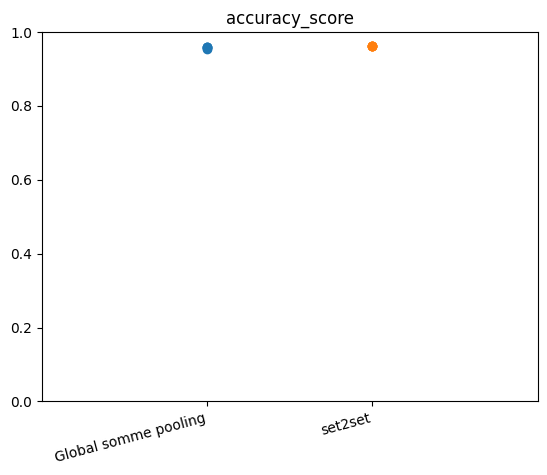

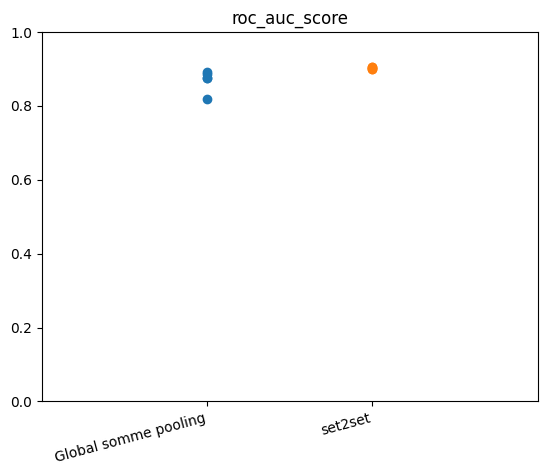

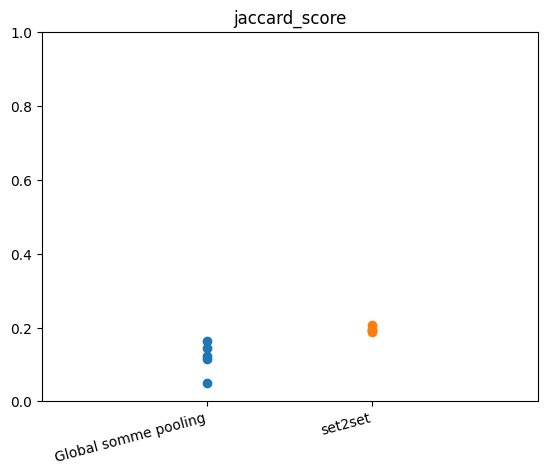

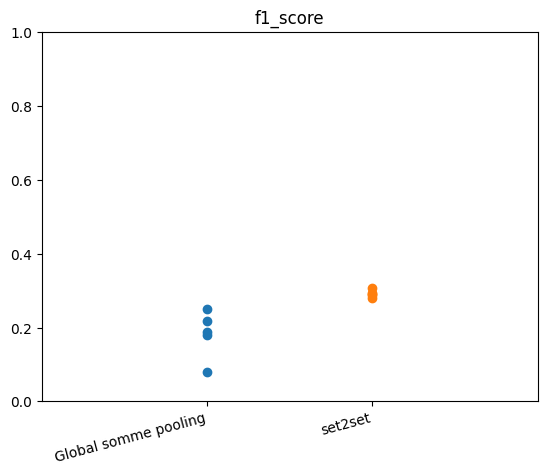

In [53]:
for metr in indice:
    x_positions = []  # Stocker les positions des ticks
    labels = []  # Stocker les labels des ticks

    i = 1  # Commencer l'indexation des positions à 1
    for dim, scores in Pred_readout_funct.items():
        y_values = [score[metr] for score in scores]
        plt.scatter([i] * len(y_values), y_values)
        
        x_positions.append(i)  # Ajouter la position du tick
        labels.append(f"{dim}")  # Ajouter le label du tick
        
        i += 1  # Passer à la prochaine position
    
    plt.xticks(x_positions, labels, rotation=15, ha="right")  # Centrer les labels
    plt.axis([0, len(Pred_readout_funct) + 1, 0, 1])
    plt.title(metr)
    save_path = f"./precision/READOUT/scatter/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    plt.show()

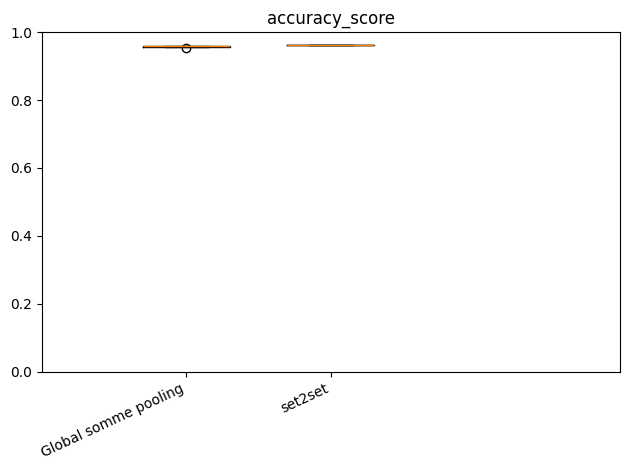

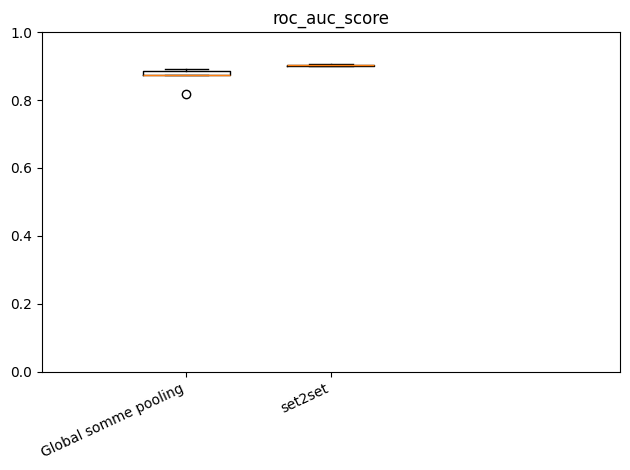

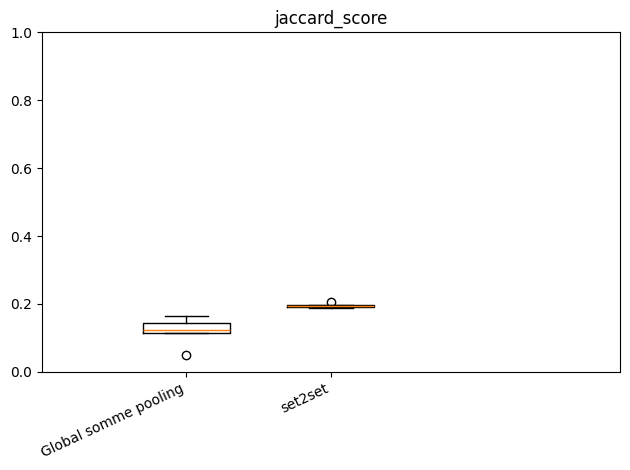

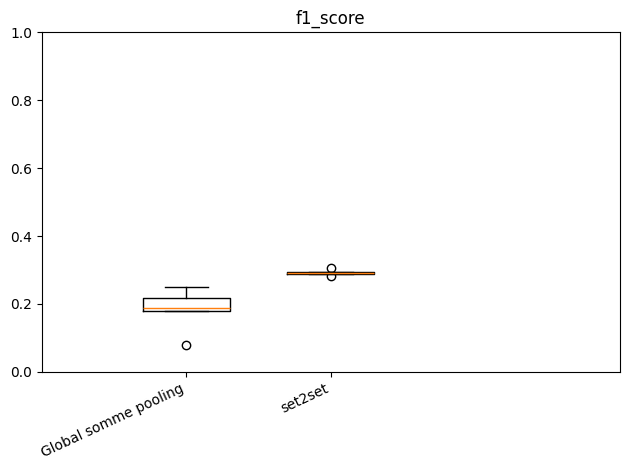

In [51]:
for metr in indice:
    i=0
    for (dim,scores) in Pred_readout_funct.items():
        i+=1        
        plt.boxplot([score[metr] for score in scores], positions=[i], widths=0.6)
    plt.gca().xaxis.set_ticklabels([f"{dim}" for dim in Pred_readout_funct.keys()])
    plt.axis([0,4,0,1])
    plt.xticks(rotation=25, ha="right") 
    plt.title(metr)
    plt.tight_layout()
    
    save_path = f"./precision/READOUT/boxplot/"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path+metr)
    
    plt.show()

### On supprime les odeurs qui ne sont pas des feuille

In [43]:
df = pd.read_csv("Individual_label.csv")
TASKS_ind = list(df.columns)
TASKS_ind.remove("Smiles")

In [27]:
def guess(Dataset, Predictions, Not_individuals, graph_ttl=g):
    Predictions = (Predictions > 0.5).astype(int)
    nb_ligne, nb_columns = Predictions.shape
    New_Prediction = np.concatenate( (Predictions, np.zeros((nb_ligne, len(Not_individuals) ))), axis=1 )
    df_pred = pd.DataFrame(New_Prediction, columns=list(Dataset.tasks) + Not_individuals)
    for col in Dataset.tasks:
        quer = f""" 
        Select ?od_parent WHERE {{ 
            :{col} a ?od_parent . 
        }} """
        for res in g.query(quer):
            q = f"""
                Select ?parent WHERE{{ 
                    :{res[0].fragment} rdfs:subClassOf ?parent
                    }}
            """
            for res2 in g.query(q):
                if res2[0].fragment in Not_individuals:
                    df_pred[res2[0].fragment] = df_pred[res2[0].fragment] + df_pred[col]
    df_pred.applymap(lambda x: 1 if isinstance(x,int) and x>=1 else x )
    Smiles = pd.DataFrame({"smiles" : Dataset.ids}) 
    return pd.concat([Smiles,df_pred.reindex(sorted(df_pred.columns), axis=1)], axis=1)
                
    

In [45]:
def get_file(data_frame, file_name ='Mol_odeur.csv'):
    Labels = list(data_frame.columns)
    df = pd.read_csv(file_name, usecols=Labels)
    print(len(df.index) - len(df['smiles'].unique()))
    return df.filter(items=data_frame['smiles'], axis=0)
    